# Predicting the Next Netflix Breakout Star

#### Jae H. Cho
#### 11/04/2022

### For this assignment we wish to make a prediction about who a breakout star actor or director will be according to the Netflix data. 

### In this paritcular case, I will define a “star” as an actor, actress, or director that is likely to star in popular movies or tv shows. Seeing as we are provided with a dataset that includes movie and show ratings, the best way to showcase a star's success and performanc would be based on these quantitative measures.

### Other factors including the performance rating of the actor, the age/date of birth at the time of the movie release, or past awards would be useful, but are not provided in this particular dataset. 

### 1) Import packages and libraries

#### Instructions: Before runnning libraries, install kaggle on anaconda. Go to applications, search 'Anaconda' and then open the command prompt. After opening, 'pip install kaggle' and while that is loading, create a kaggle account on kaggle.com. After running the cell, an OSError: Could not find kaggle.json.....error will pop up. Login to your newly created kaggle account, click the top right user icon and select 'account'. Scroll down and click 'Create New API Token' in the API section and save it in the .kaggle folder

In [84]:
import kaggle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import ast

from sklearn import linear_model

from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

#### There are 2 choices. 
#### 2a) You can simply download the kaggle csv files themselves after creating a kaggle account
#### 2b) Or you can call the data files with an API call and extract the zip file containing the files

### 2a) Read the data files

In [85]:
# credits = pd.read_csv(r'credits.csv')
# titles = pd.read_csv(r'titles.csv')

### 2b) Call the API

In [86]:
api = KaggleApi()
api.authenticate()

In [87]:
# Download the dataset containing the 2 data files

api.dataset_download_files('victorsoeiro/netflix-tv-shows-and-movies')

In [88]:
# Unzip the zipped files of the data

with zipfile.ZipFile('netflix-tv-shows-and-movies.zip', 'r') as zipref:
    zipref.extractall()

In [89]:
credits = pd.read_csv(r'credits.csv', encoding = 'utf-8')
titles = pd.read_csv(r'titles.csv', encoding = 'utf-8')

### 3) Merge datasets based on the shared 'id' column

In [90]:
# This is our mapping step, where we will join the 2 data sets based on the unique id given to each actor

df = pd.merge(titles, credits, how = 'inner', on = 'id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77801 entries, 0 to 77800
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    77801 non-null  object 
 1   title                 77800 non-null  object 
 2   type                  77801 non-null  object 
 3   description           77763 non-null  object 
 4   release_year          77801 non-null  int64  
 5   age_certification     46658 non-null  object 
 6   runtime               77801 non-null  int64  
 7   genres                77801 non-null  object 
 8   production_countries  77801 non-null  object 
 9   seasons               14710 non-null  float64
 10  imdb_id               74302 non-null  object 
 11  imdb_score            73851 non-null  float64
 12  imdb_votes            73764 non-null  float64
 13  tmdb_popularity       77790 non-null  float64
 14  tmdb_score            76664 non-null  float64
 15  person_id          

#### After combining our 2 datasets (mapping each actor and role to their specified work, we have a total of 77,801 rows of data with 19 columns of variables (qualitative and quantitative.

#### We can see that there are several null (empty) values present in the datase. To determine whether an actor or actress will become a breakouot/rising star, the ratings may be a potential quantitative factor in this.

#### Therefore, we should clean the data, by removing the rows with null values for those particular rating measures.

In [91]:
# We can see that imdb votes, imdb scores, tmdb popularities, and tmdb scores are missing pieces of data that may be 
# essential for analysis.

# Create a copy of the dataframe (df) to work with
df2 = df.copy()
df2 = df2.dropna(subset=['imdb_votes','imdb_score','tmdb_popularity','tmdb_score', 'title'])

# 2 particular rows are not shown as null(Nan) but rather as '[]' strings for the genres, which are still empty values.
# I went ahead and searched on Google and replaced the null genres with the correct genre type.
df2.loc[29631, 'genres'] = "['comedy']"
df2.loc[37731, "genres"] = "['comedy']"

df2['id'] = df2['id'].astype(str)                                # Remove null spaces and convert these numbers to strings
df2['id'] = df2['id'].str.replace(' ', '')
#--------------------------------------------------------------------------------------------------------------------------
df2['person_id'] = df2['person_id'].astype(str)
df2['person_id'] = df2['person_id'].str.replace(' ', '')
#--------------------------------------------------------------------------------------------------------------------------
df2['imdb_id'] = df2['imdb_id'].astype(str)
df2['imdb_id'] = df2['imdb_id'].str.replace(' ', '')
#--------------------------------------------------------------------------------------------------------------------------
df2['imdb_votes'] = df2['imdb_votes'].astype(int)
#--------------------------------------------------------------------------------------------------------------------------
df2['seasons'].fillna(0, inplace = True)
df2['seasons'] = df2['seasons'].astype(int)
#--------------------------------------------------------------------------------------------------------------------------
df2['age_certification'].fillna('UNK', inplace = True)
#--------------------------------------------------------------------------------------------------------------------------
# Created a column to keep count when planning to group the data by id for particular fields (genres, projects, etc)
df2['count'] = int(1)
#--------------------------------------------------------------------------------------------------------------------------
# Notice that some character names are null, so we can fill in by replacing with 'Unknown'
df2['character'].fillna("Unkonwn", inplace = True)
#--------------------------------------------------------------------------------------------------------------------------
# View the dataframe
df2

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id,name,character,role,count
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],0,tt0075314,8.2,808582,40.965,8.179,3748,Robert De Niro,Travis Bickle,ACTOR,1
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],0,tt0075314,8.2,808582,40.965,8.179,14658,Jodie Foster,Iris Steensma,ACTOR,1
2,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],0,tt0075314,8.2,808582,40.965,8.179,7064,Albert Brooks,Tom,ACTOR,1
3,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],0,tt0075314,8.2,808582,40.965,8.179,3739,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR,1
4,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],0,tt0075314,8.2,808582,40.965,8.179,48933,Cybill Shepherd,Betsy,ACTOR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77796,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,UNK,90,['comedy'],['CO'],0,tt14585902,3.8,68,26.005,6.300,736339,Adelaida Buscato,María Paz,ACTOR,1
77797,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,UNK,90,['comedy'],['CO'],0,tt14585902,3.8,68,26.005,6.300,399499,Luz Stella Luengas,Karen Bayona,ACTOR,1
77798,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,UNK,90,['comedy'],['CO'],0,tt14585902,3.8,68,26.005,6.300,373198,Inés Prieto,Fanny,ACTOR,1
77799,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,UNK,90,['comedy'],['CO'],0,tt14585902,3.8,68,26.005,6.300,378132,Isabel Gaona,Cacica,ACTOR,1


#### We are left with 72,941 rows of data after removing null values from our rating values. We can see there is a category called 'tmdb_popularity'. After researching online, this variable can relate to many different fields whether it be a vote, daily, monthly, how many steps it was moved up or down, and has not limit value. This may not be useful in our analysis, as we don't necessarily know that this value actually means.

In [92]:
# Remove description, character name, and imdb_id variables from our analysis
df2.drop(['description', 'tmdb_popularity', 'character', 'imdb_id'], axis=1, inplace = True)

# It's also important to remember that the Kaggle dataset marks the list value fields as blank rather than n/a or 
# NaN if they are missing a genre or production country. After already having checked genre, we will now remove 
# the production_countries where the value is displayed as '[ ]'.
df2 = df2[df2['production_countries'] != '[]']

df2

,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_score,person_id,name,role,count
0,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,3748,Robert De Niro,ACTOR,1
1,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,14658,Jodie Foster,ACTOR,1
2,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,7064,Albert Brooks,ACTOR,1
3,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,3739,Harvey Keitel,ACTOR,1
4,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,48933,Cybill Shepherd,ACTOR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77796,tm1059008,Lokillo,MOVIE,2021,UNK,90,['comedy'],['CO'],0,3.8,68,6.300,736339,Adelaida Buscato,ACTOR,1
77797,tm1059008,Lokillo,MOVIE,2021,UNK,90,['comedy'],['CO'],0,3.8,68,6.300,399499,Luz Stella Luengas,ACTOR,1
77798,tm1059008,Lokillo,MOVIE,2021,UNK,90,['comedy'],['CO'],0,3.8,68,6.300,373198,Inés Prieto,ACTOR,1
77799,tm1059008,Lokillo,MOVIE,2021,UNK,90,['comedy'],['CO'],0,3.8,68,6.300,378132,Isabel Gaona,ACTOR,1


#### Genre Plot

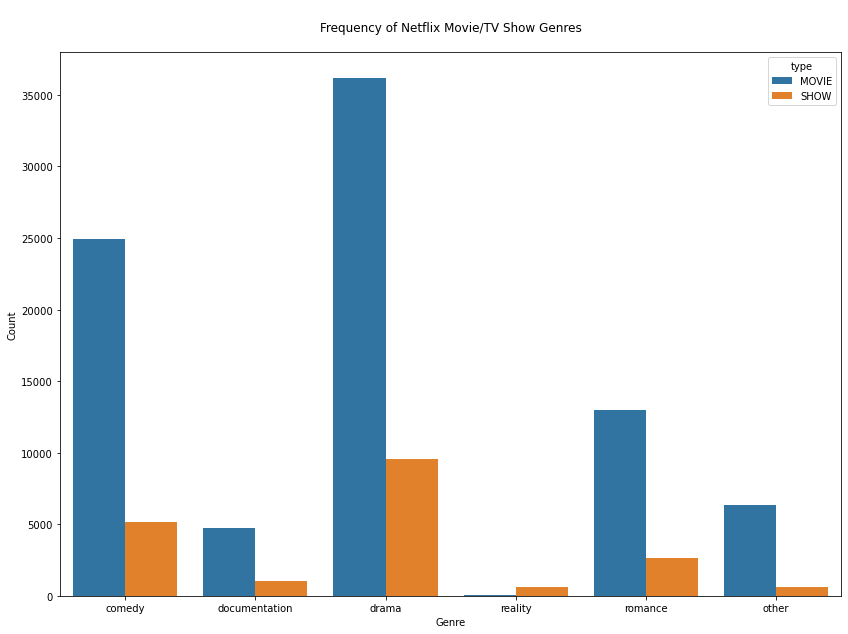

In [97]:
pd.options.mode.chained_assignment = None

df_comedy = df2[df2['genres'].str.contains("'comedy'")]
df_comedy.loc[:, 'genres'] = 'comedy'

df_drama = df2[df2['genres'].str.contains("'drama'")]
df_drama.loc[:, 'genres'] = 'drama'

df_doc = df2[df2['genres'].str.contains("'documentation'")]
df_doc.loc[:, 'genres'] = 'documentation'

df_reality = df2[df2['genres'].str.contains('reality')]
df_reality.loc[:, 'genres'] = 'reality'

df_romance = df2[df2['genres'].str.contains('romance')]
df_romance.loc[:, 'genres'] = 'romance'

df_other = df2[~((df2["genres"].str.contains("'comedy'")) |\
              (df2["genres"].str.contains("'drama'"))|\
              (df2["genres"].str.contains("'documentation'"))|\
           (df2["genres"].str.contains("'reality'"))|\
           (df2["genres"].str.contains("'romance'")))]

df_other.loc[:, 'genres'] = 'other'

df_genres = pd.concat([df_comedy, df_doc, df_drama, df_reality, df_romance, df_other], ignore_index = True)
#--------------------------------------------------------------------------------------------------------------------------

# Plot
plt.figure(figsize = (14, 10))
ax = sns.countplot(x = 'genres', data = df_genres, hue = 'type')


    
ax.set_title('\nFrequency of Netflix Movie/TV Show Genres\n')
ax.set_xlabel('Genre')
ax.set_ylabel('Count');

#### We now convert our strings to lists

### 4) Clean genre (convert strings to list)

In [98]:
def cleanGenres(arr):
    arr=ast.literal_eval(arr)
    
    if len(arr) == 0:
        return np.nan
    
    elif len(arr) == 1:
        return arr[0]
    
    else:
        return 'MULTI-GENRE'

### 5) Clean production countries (convert strings to list)

In [99]:
def cleanProduction(arr):
    arr=ast.literal_eval(arr)
    
    if len(arr) == 0:
        return np.nan
    
    elif len(arr) == 1:
        return [arr[0]]
    
    else:
        return arr

In [100]:
pd.options.mode.chained_assignment = None  # ignore the default = warning for a chain assignment

# Apply functions to our dataframe to convert our strings to lists
df2['genres_cleaned'] = df2['genres'].apply(cleanGenres)
df2['pc_cleaned'] = df2['production_countries'].apply(cleanProduction)

df2['genres_c2'] = df2['genres_cleaned'].str.len().astype(int)
df2['pc_c2'] = df2['pc_cleaned'].str.len().astype(int)

df2

,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_score,person_id,name,role,count,genres_cleaned,pc_cleaned,genres_c2,pc_c2
0,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,3748,Robert De Niro,ACTOR,1,MULTI-GENRE,[US],11,1
1,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,14658,Jodie Foster,ACTOR,1,MULTI-GENRE,[US],11,1
2,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,7064,Albert Brooks,ACTOR,1,MULTI-GENRE,[US],11,1
3,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,3739,Harvey Keitel,ACTOR,1,MULTI-GENRE,[US],11,1
4,tm84618,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],0,8.2,808582,8.179,48933,Cybill Shepherd,ACTOR,1,MULTI-GENRE,[US],11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77796,tm1059008,Lokillo,MOVIE,2021,UNK,90,['comedy'],['CO'],0,3.8,68,6.300,736339,Adelaida Buscato,ACTOR,1,comedy,[CO],6,1
77797,tm1059008,Lokillo,MOVIE,2021,UNK,90,['comedy'],['CO'],0,3.8,68,6.300,399499,Luz Stella Luengas,ACTOR,1,comedy,[CO],6,1
77798,tm1059008,Lokillo,MOVIE,2021,UNK,90,['comedy'],['CO'],0,3.8,68,6.300,373198,Inés Prieto,ACTOR,1,comedy,[CO],6,1
77799,tm1059008,Lokillo,MOVIE,2021,UNK,90,['comedy'],['CO'],0,3.8,68,6.300,378132,Isabel Gaona,ACTOR,1,comedy,[CO],6,1


### 6) Group/aggregate the data to check for mispelled names or other variations associated with the id

In [101]:
# Group our dataset by the provided id, to see all the projects and ratigns associated with each actor, 
# actress, and director

group = df2.groupby(by = 'person_id').agg({"name":"unique", "title":"unique", "role": "unique", "imdb_score":"sum",
                                           "tmdb_score":"sum", "count":"sum", "pc_c2":"unique", "genres_c2":"unique",
                                           "age_certification":"unique", "runtime":"unique", "type":"unique", 
                                           'imdb_votes':'sum'})
group = group.reset_index()

group

,person_id,name,title,role,imdb_score,tmdb_score,count,pc_c2,genres_c2,age_certification,runtime,type,imdb_votes
0,1000,[Martin Sheen],"[Spawn, Catch Me If You Can, The Departed, The...",[ACTOR],42.9,41.643,6,[1],"[11, 5]","[PG-13, R, TV-MA, UNK]","[96, 141, 151, 136, 29, 106]","[MOVIE, SHOW]",3016572
1,1000027,[Gloria García],[Afterlife of the Party],[ACTOR],5.8,6.900,1,[1],[11],[UNK],[109],[MOVIE],8728
2,100004,[Christopher Von Uckermann],[How to Get Over a Breakup],[ACTOR],6.1,6.800,1,[1],[6],[UNK],[104],[MOVIE],2003
3,100007,[Dulce María],[Falsa identidad],[ACTOR],7.0,7.500,1,[2],[11],[TV-14],[43],[SHOW],358
4,10001,[Matthew Macfadyen],[Operation Mincemeat],[ACTOR],6.6,6.700,1,[2],[11],[PG-13],[128],[MOVIE],18893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51752,9997,[Michael Vardian],[Rush],[ACTOR],8.1,7.700,1,[3],[11],[R],[123],[MOVIE],471586
51753,999705,[Rachel Bay Jones],[Ben Is Back],[ACTOR],6.7,6.600,1,[1],[11],[R],[103],[MOVIE],21735
51754,9998,[Eddie Bagayawa],[Rush],[ACTOR],8.1,7.700,1,[3],[11],[R],[123],[MOVIE],471586
51755,99987,[Jason Barry],[Titanic],[ACTOR],7.9,7.878,1,[1],[11],[PG-13],[194],[MOVIE],1146825


#### Create functions to clean categoris for roles and age_certifications (ratings of movies)

In [102]:
def actorScale(arr):
    if len(arr) == 0:
        return np.nan
    
    elif len(arr) == 1:
        return arr[0]
    
    else:
        return 'ACTOR, DIRECTOR'

In [103]:
def ageCert(arr):
    if len(arr) == 0:
        return np.nan
    
    elif len(arr) == 1:
        return arr[0]
    
    else:
        return 'MULTIPLE'

In [104]:
group['role'] = group['role'].apply(actorScale)
group['age_certification'] = group['age_certification'].apply(ageCert)
group

,person_id,name,title,role,imdb_score,tmdb_score,count,pc_c2,genres_c2,age_certification,runtime,type,imdb_votes
0,1000,[Martin Sheen],"[Spawn, Catch Me If You Can, The Departed, The...",ACTOR,42.9,41.643,6,[1],"[11, 5]",MULTIPLE,"[96, 141, 151, 136, 29, 106]","[MOVIE, SHOW]",3016572
1,1000027,[Gloria García],[Afterlife of the Party],ACTOR,5.8,6.900,1,[1],[11],UNK,[109],[MOVIE],8728
2,100004,[Christopher Von Uckermann],[How to Get Over a Breakup],ACTOR,6.1,6.800,1,[1],[6],UNK,[104],[MOVIE],2003
3,100007,[Dulce María],[Falsa identidad],ACTOR,7.0,7.500,1,[2],[11],TV-14,[43],[SHOW],358
4,10001,[Matthew Macfadyen],[Operation Mincemeat],ACTOR,6.6,6.700,1,[2],[11],PG-13,[128],[MOVIE],18893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51752,9997,[Michael Vardian],[Rush],ACTOR,8.1,7.700,1,[3],[11],R,[123],[MOVIE],471586
51753,999705,[Rachel Bay Jones],[Ben Is Back],ACTOR,6.7,6.600,1,[1],[11],R,[103],[MOVIE],21735
51754,9998,[Eddie Bagayawa],[Rush],ACTOR,8.1,7.700,1,[3],[11],R,[123],[MOVIE],471586
51755,99987,[Jason Barry],[Titanic],ACTOR,7.9,7.878,1,[1],[11],PG-13,[194],[MOVIE],1146825


In [105]:
# Example usage when checking for duplicates. No duplicates were found (if there were that was because the actor had the 
# same name, same movie/tv show, but played 2 characters, or was also the director in the project)

# df_roles = df2[df2.duplicated(['person_id','title'], keep = False)]
# df_roles.sort_values(by = 'person_id', ascending = False)

### 7) Create a predictor variable y that determines a rating score based on the actor's previous works

In [106]:
# I will use score as a predictor on whether or not the actor will 'breakout' as a star, by averaging the ratigns of the
# imdb and tmdb scores of every movie or tv-show the particular person has been in.

group['Name'] = group['name'].str[0]

group['title_count'] = group['title'].str.len()
group['type_count'] = group['type'].str.len()

# Use averages to use as a quantitative measures of rating scores
group['total_runtime'] = group['runtime'].apply(sum)
group['runtime_count'] = group['runtime'].str.len()
group['avg_runtime'] = group['total_runtime'] / group['runtime_count']

group['avg_pop_c'] = (group['pc_c2'].apply(sum)) / (group['pc_c2'].str.len())
group['avg_genres'] = (group['genres_c2'].apply(sum)) / (group['genres_c2'].str.len())
group['avg_imdb_score'] = group['imdb_score'] / group['count']
group['avg_tmdb_score'] = group['tmdb_score'] / group['count']

group['avg_runtime'] = group['total_runtime'] / group['runtime_count']
group['avg_imdb_votes'] = group['imdb_votes'] / group['count']

group['rating_total'] = 2 * (group['count'].astype(int))         #each movie or tv show wil have an imdb and a tmdb rating
group['total_scores'] = group['imdb_score'] + (group['tmdb_score'])

group['score'] = group['total_scores'] / group['rating_total']

group.sort_values(by='score', ascending=False)

,person_id,name,title,role,imdb_score,tmdb_score,count,pc_c2,genres_c2,age_certification,...,runtime_count,avg_runtime,avg_pop_c,avg_genres,avg_imdb_score,avg_tmdb_score,avg_imdb_votes,rating_total,total_scores,score
22703,2251032,[Manwendra Tripathy],"[Raja, Rasoi Aur Anya Kahaniyaan]",ACTOR,8.9,10.00,1,[1],[11],UNK,...,1,29.0,1.0,11.0,8.9,10.00,333.0,2,18.90,9.450
22819,2259188,[Dr Pushpesh Pant],"[Raja, Rasoi Aur Anya Kahaniyaan]",ACTOR,8.9,10.00,1,[1],[11],UNK,...,1,29.0,1.0,11.0,8.9,10.00,333.0,2,18.90,9.450
42898,730099,[tooniverse],[The Haunted House],DIRECTOR,8.3,10.00,1,[1],[11],TV-PG,...,1,25.0,1.0,11.0,8.3,10.00,83.0,2,18.30,9.150
32308,37752,[Anna Gunn],[Breaking Bad],ACTOR,9.5,8.79,1,[1],[11],TV-MA,...,1,48.0,1.0,11.0,9.5,8.79,1775990.0,2,18.29,9.145
41201,681724,[Bassel Khayyat],[The Writer],ACTOR,8.2,10.00,1,[1],[11],TV-14,...,1,37.0,1.0,11.0,8.2,10.00,32.0,2,18.20,9.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6758,127911,[Krishna Abhishek],[Kyaa Kool Hain Hum 3],ACTOR,1.9,3.10,1,[1],[6],UNK,...,1,124.0,1.0,6.0,1.9,3.10,4356.0,2,5.00,2.500
6759,127912,[Meghna Naidu],[Kyaa Kool Hain Hum 3],ACTOR,1.9,3.10,1,[1],[6],UNK,...,1,124.0,1.0,6.0,1.9,3.10,4356.0,2,5.00,2.500
6763,127914,[Gizele Thakral],[Kyaa Kool Hain Hum 3],ACTOR,1.9,3.10,1,[1],[6],UNK,...,1,124.0,1.0,6.0,1.9,3.10,4356.0,2,5.00,2.500
6764,127915,[Claudia Ciesla],[Kyaa Kool Hain Hum 3],ACTOR,1.9,3.10,1,[1],[6],UNK,...,1,124.0,1.0,6.0,1.9,3.10,4356.0,2,5.00,2.500


In [107]:
# Star: If the actor/actress/director has a score of at least 8, then he/she will be classified as a breakout star.
# Seeing as the max of the ratings was ~9.45, 8 is a reasonable cut-off

def calcStar(score):
    if score >= 8:
        return int(1)
    else:
        return int(0)

In [108]:
group['star'] = group['score'].apply(calcStar)
group

,person_id,name,title,role,imdb_score,tmdb_score,count,pc_c2,genres_c2,age_certification,...,avg_runtime,avg_pop_c,avg_genres,avg_imdb_score,avg_tmdb_score,avg_imdb_votes,rating_total,total_scores,score,star
0,1000,[Martin Sheen],"[Spawn, Catch Me If You Can, The Departed, The...",ACTOR,42.9,41.643,6,[1],"[11, 5]",MULTIPLE,...,109.833333,1.0,8.0,7.15,6.9405,502762.0,12,84.543,7.04525,0
1,1000027,[Gloria García],[Afterlife of the Party],ACTOR,5.8,6.900,1,[1],[11],UNK,...,109.000000,1.0,11.0,5.80,6.9000,8728.0,2,12.700,6.35000,0
2,100004,[Christopher Von Uckermann],[How to Get Over a Breakup],ACTOR,6.1,6.800,1,[1],[6],UNK,...,104.000000,1.0,6.0,6.10,6.8000,2003.0,2,12.900,6.45000,0
3,100007,[Dulce María],[Falsa identidad],ACTOR,7.0,7.500,1,[2],[11],TV-14,...,43.000000,2.0,11.0,7.00,7.5000,358.0,2,14.500,7.25000,0
4,10001,[Matthew Macfadyen],[Operation Mincemeat],ACTOR,6.6,6.700,1,[2],[11],PG-13,...,128.000000,2.0,11.0,6.60,6.7000,18893.0,2,13.300,6.65000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51752,9997,[Michael Vardian],[Rush],ACTOR,8.1,7.700,1,[3],[11],R,...,123.000000,3.0,11.0,8.10,7.7000,471586.0,2,15.800,7.90000,0
51753,999705,[Rachel Bay Jones],[Ben Is Back],ACTOR,6.7,6.600,1,[1],[11],R,...,103.000000,1.0,11.0,6.70,6.6000,21735.0,2,13.300,6.65000,0
51754,9998,[Eddie Bagayawa],[Rush],ACTOR,8.1,7.700,1,[3],[11],R,...,123.000000,3.0,11.0,8.10,7.7000,471586.0,2,15.800,7.90000,0
51755,99987,[Jason Barry],[Titanic],ACTOR,7.9,7.878,1,[1],[11],PG-13,...,194.000000,1.0,11.0,7.90,7.8780,1146825.0,2,15.778,7.88900,0


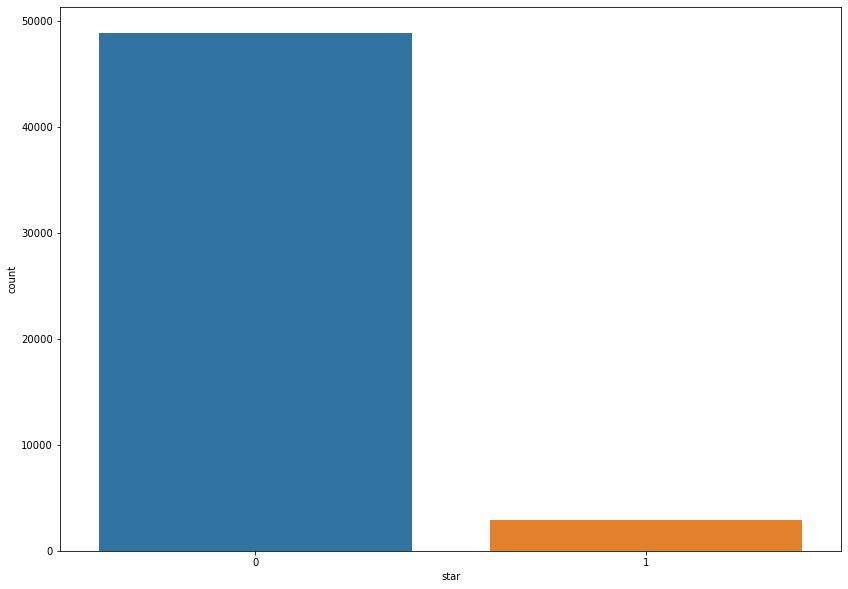

In [113]:
plt.figure(figsize = (14, 10))
ax = sns.countplot(x = 'star', data = group)


### 8) Create a final dataframe to use for final analysis to determine whether our model will be useful. 

#### To avoid further bias in the modle, I will eliminate the tmdb score variale as imdb scores tend to correlate with it.

In [114]:
final_df = group[['star', 'type_count', 'role', 'avg_runtime', 'avg_genres', 'avg_pop_c', 'avg_imdb_votes', 'avg_imdb_score','age_certification']]

(7.5, -0.5)

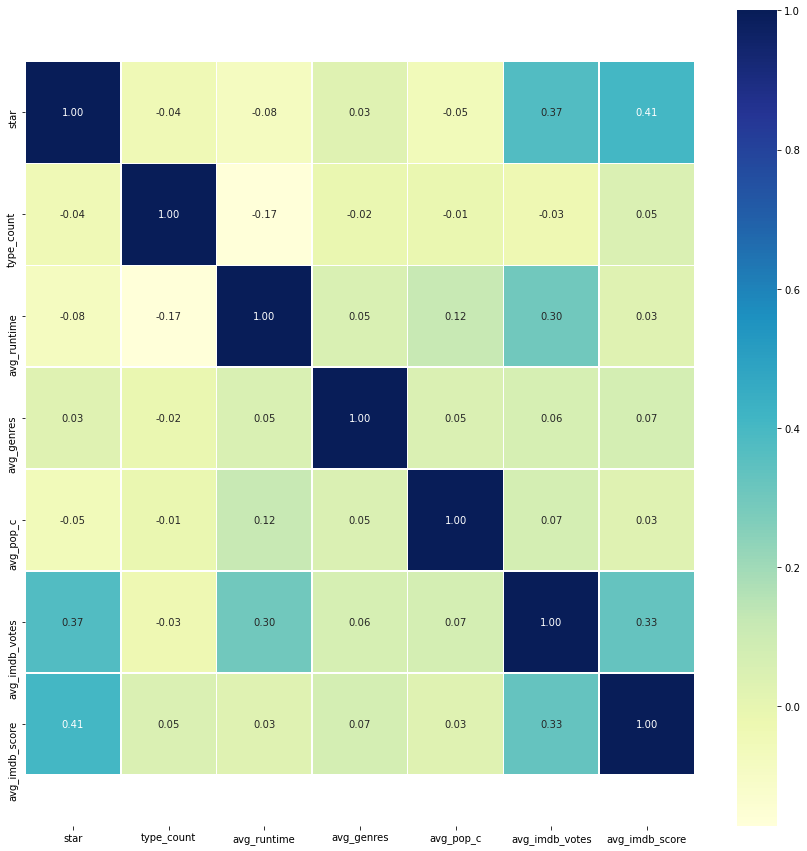

In [115]:
corr_matrix = final_df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### 9) Define categorical and quantitative variables

In [116]:
categorical_val = ['type_count', 'role', 'age_certification']
data = pd.get_dummies(final_df, columns = categorical_val)

In [117]:
from sklearn.preprocessing import StandardScaler

s_sc = StandardScaler()
col_to_scale = ['avg_runtime', 'avg_genres', 'avg_pop_c', 'avg_imdb_score', 'avg_imdb_votes']
data[col_to_scale] = s_sc.fit_transform(data[col_to_scale])

In [118]:
data.head()

,star,avg_runtime,avg_genres,avg_pop_c,avg_imdb_votes,avg_imdb_score,type_count_1,type_count_2,role_ACTOR,"role_ACTOR, DIRECTOR",...,age_certification_PG,age_certification_PG-13,age_certification_R,age_certification_TV-14,age_certification_TV-G,age_certification_TV-MA,age_certification_TV-PG,age_certification_TV-Y,age_certification_TV-Y7,age_certification_UNK
0,0,0.380578,-1.454561,-0.426373,2.258320,0.660506,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.354717,0.345463,-0.426373,-0.314749,-0.624755,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.199552,-2.654577,-0.426373,-0.349774,-0.339142,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,-1.693455,0.345463,1.123813,-0.358342,0.517700,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0.944342,0.345463,1.123813,-0.261806,0.136881,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### 10) Perform Machine Learning on the data

In [119]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [120]:
from sklearn.model_selection import train_test_split

X = data.drop('star', axis=1)
y = data.star

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [121]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 97.73%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.984146     0.846194   0.97733      0.915170      0.976299
recall         0.991942     0.735054   0.97733      0.863498      0.977330
f1-score       0.988029     0.786718   0.97733      0.887373      0.976578
support    36609.000000  2208.000000   0.97733  38817.000000  38817.000000
_______________________________________________
Confusion Matrix: 
 [[36314   295]
 [  585  1623]]

Test Result:
Accuracy Score: 97.66%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.983619    0.834154  0.976584      0.908886      0.975418
recall         0.991742    0.715493  0.976584      0.853617      0.976584
f1-score       0.987663    0.770281  0.976584      0.878972      0.975736
support    122

In [122]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.34%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.995529     0.957377  0.993431      0.976453      0.993359
recall         0.997514     0.925725  0.993431      0.961619      0.993431
f1-score       0.996521     0.941285  0.993431      0.968903      0.993379
support    36609.000000  2208.000000  0.993431  38817.000000  38817.000000
_______________________________________________
Confusion Matrix: 
 [[36518    91]
 [  164  2044]]

Test Result:
Accuracy Score: 99.11%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.994449    0.931785  0.991113      0.963117      0.991011
recall         0.996157    0.904225  0.991113      0.950191      0.991113
f1-score       0.995302    0.917798  0.991113      0.956550      0.991050
support    122

In [123]:
from sklearn.svm import SVC


svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_clf.fit(X_train, y_train)

print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 98.19%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.987747     0.874129  0.981864      0.930938      0.981284
recall         0.993089     0.795743  0.981864      0.894416      0.981864
f1-score       0.990411     0.833096  0.981864      0.911754      0.981462
support    36609.000000  2208.000000  0.981864  38817.000000  38817.000000
_______________________________________________
Confusion Matrix: 
 [[36356   253]
 [  451  1757]]

Test Result:
Accuracy Score: 98.28%
_______________________________________________
CLASSIFICATION REPORT:
                      0           1  accuracy     macro avg  weighted avg
precision      0.988765    0.870624  0.982767      0.929695      0.982283
recall         0.993050    0.805634  0.982767      0.899342      0.982767
f1-score       0.990903    0.836869  0.982767      0.913886      0.982451
support    122

## 11) View Finalized Model

In [124]:
# This dataframe shows our predicted breakout starts based on the model accuracy.

final_df = group[group['star'] == 1]
final_df.sort_values(by='score', ascending=False)

,person_id,name,title,role,imdb_score,tmdb_score,count,pc_c2,genres_c2,age_certification,...,avg_runtime,avg_pop_c,avg_genres,avg_imdb_score,avg_tmdb_score,avg_imdb_votes,rating_total,total_scores,score,star
22703,2251032,[Manwendra Tripathy],"[Raja, Rasoi Aur Anya Kahaniyaan]",ACTOR,8.9,10.00,1,[1],[11],UNK,...,29.0,1.0,11.0,8.9,10.00,333.0,2,18.90,9.450,1
22819,2259188,[Dr Pushpesh Pant],"[Raja, Rasoi Aur Anya Kahaniyaan]",ACTOR,8.9,10.00,1,[1],[11],UNK,...,29.0,1.0,11.0,8.9,10.00,333.0,2,18.90,9.450,1
42898,730099,[tooniverse],[The Haunted House],DIRECTOR,8.3,10.00,1,[1],[11],TV-PG,...,25.0,1.0,11.0,8.3,10.00,83.0,2,18.30,9.150,1
32308,37752,[Anna Gunn],[Breaking Bad],ACTOR,9.5,8.79,1,[1],[11],TV-MA,...,48.0,1.0,11.0,9.5,8.79,1775990.0,2,18.29,9.145,1
18942,1961604,[Reem Khoury],[The Writer],ACTOR,8.2,10.00,1,[1],[11],TV-14,...,37.0,1.0,11.0,8.2,10.00,32.0,2,18.20,9.100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24080,233792,[Badava Gopi],[K. D.],ACTOR,8.4,7.60,1,[1],[5],UNK,...,119.0,1.0,5.0,8.4,7.60,1787.0,2,16.00,8.000,1
41804,699228,[Abu Valayankulam],[Merku Thodarchi Malai],ACTOR,8.6,7.40,1,[1],[5],UNK,...,122.0,1.0,5.0,8.6,7.40,1818.0,2,16.00,8.000,1
1535,105600,[Terrence Mann],[Sense8],ACTOR,8.2,7.80,1,[1],[11],TV-MA,...,62.0,1.0,11.0,8.2,7.80,152865.0,2,16.00,8.000,1
41803,699227,[Anthony Vaathiyaar],[Merku Thodarchi Malai],ACTOR,8.6,7.40,1,[1],[5],UNK,...,122.0,1.0,5.0,8.6,7.40,1818.0,2,16.00,8.000,1


## 12) Export finalized model

In [125]:
# final_df.to_csv("output_file.csv",index=False)

## 13) Conclusion

### Ultimately, the outcome for the model's accuracy score seems surprisingly high, as this may be due to other independent variables. Bias is always present to some degree in peforming data analysis to find a more accruate model to best predict or display one's results. Kirsten Barkved from Obviously.ai states that "anything greater than 70% is a great model performance.. an accuracy measure of anything between 70%-90% is not only ideal, it’s realistic."

### Although the logistic regression ML model proved to have the lowest accruacy from the models tested, it seems to have a more 'realistic' accuracry score compared to the other scores.

### A breakout star has several variables that may be associated to one's success to star in another popular movie or tv show. The level of performance, the role of the character, the quality of the work, popularity votes and ratings by the audiences, critic review scores, quality of the story, and set chemistry. If more of these variables were included in the study, the outcome would be closer to a realistic prediction. The outcome of this analysis is primarily focused on the imdb ratings and the quantity (measured in averages) of the total genres, projects, types of projects, and the roles played in each project. 